In [1]:
import matplotlib.pyplot as plt
import numpy as np
from skimage import io
import glob
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

# Preparing The Data

In [2]:
DATASET_PATH = "../input/flowersrecognition/flowers"
flowers_cls = ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']  

In [3]:
flower_path = os.path.join(DATASET_PATH, flowers_cls[1], '*')
print(flower_path)
flower_path_1 = flower_path

# glob through the directory (returns a list of all file paths)
flower_path_1 = glob.glob(flower_path_1)
image = io.imread(flower_path_1[245])
plt.imshow(image)

#print(flower_path[1]) # access an individual file

../input/flowersrecognition/flowers/dandelion/*


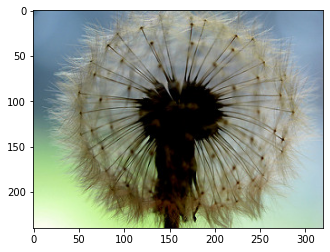

In [4]:
import random
# run this block multiple times to look at some randomly chosen images of roses
rand_index = random.randint(0, len(flower_path_1))
image = io.imread(flower_path_1[rand_index])
plt.imshow(image)

In [5]:
print(DATASET_PATH) 

../input/flowersrecognition/flowers


In [6]:
data_dir = DATASET_PATH
print(data_dir)

../input/flowersrecognition/flowers


In [7]:
img_height,img_width=180,180
#batch_size=32
BATCH_SIZE = 32
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=BATCH_SIZE)

Found 4323 files belonging to 5 classes.
Using 3459 files for training.


In [8]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=BATCH_SIZE)

Found 4323 files belonging to 5 classes.
Using 864 files for validation.


In [9]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']


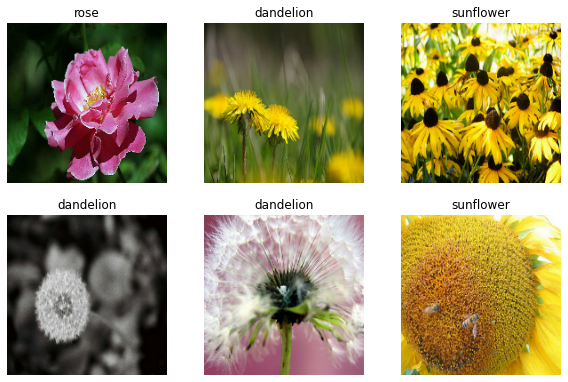

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(6):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

# Training The Model


In [11]:
resnet_model = Sequential()

pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(180,180,3),
                   pooling='avg',classes=5,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

resnet_model.add(pretrained_model)
resnet_model.add(Flatten())
resnet_model.add(Dense(512, activation='relu'))
resnet_model.add(Dense(5, activation='softmax'))

94773248/94765736 [==============================] - 2s 0us/step


In [12]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1049088   
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 2565      
Total params: 24,639,365
Trainable params: 1,051,653
Non-trainable params: 23,587,712
_________________________________________________________________


Changing the loss to 'sparse_categorical_crossentropy' solved the problem.

model.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

The error arose because 'categorical_crossentropy' works on one-hot encoded target, while 'sparse_categorical_crossentropy' works on integer target.

In [13]:
#resnet_model.compile(optimizer=Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

resnet_model.compile(optimizer=Adam(lr=0.001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])


In [14]:
num_epochs=10
history = resnet_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=num_epochs
)


#BATCH_SIZE = 32

#steps_per_epoch = BATCH_SIZE
#validation_steps = BATCH_SIZE

#history = resnet_model.fit(
 #   train_ds,
 #   epochs=5, steps_per_epoch=steps_per_epoch,
 #   validation_data=val_ds,
 #   validation_steps=validation_steps)



#epochs = 10
#history = resnet_model.fit(
#  train_ds,
#  validation_data=val_ds,
#  epochs=epochs
  #callbacks=[reduce_lr,early_stop]
#)


Epoch 1/10
109/109 [==============================] - 283s 3s/step - loss: 1.0978 - accuracy: 0.6837 - val_loss: 0.5296 - val_accuracy: 0.8275
Epoch 2/10
109/109 [==============================] - 262s 2s/step - loss: 0.3339 - accuracy: 0.8809 - val_loss: 0.3947 - val_accuracy: 0.8715
Epoch 3/10
109/109 [==============================] - 258s 2s/step - loss: 0.2335 - accuracy: 0.9109 - val_loss: 0.4365 - val_accuracy: 0.8715
Epoch 4/10
109/109 [==============================] - 256s 2s/step - loss: 0.1524 - accuracy: 0.9470 - val_loss: 0.6603 - val_accuracy: 0.8160
Epoch 5/10
109/109 [==============================] - 256s 2s/step - loss: 0.1609 - accuracy: 0.9428 - val_loss: 0.4602 - val_accuracy: 0.8750
Epoch 6/10
109/109 [==============================] - 254s 2s/step - loss: 0.0584 - accuracy: 0.9849 - val_loss: 0.5214 - val_accuracy: 0.8704
Epoch 7/10
109/109 [==============================] - 256s 2s/step - loss: 0.0537 - accuracy: 0.9858 - val_loss: 0.5068 - val_accuracy: 0.8843

# Evaluating The Model

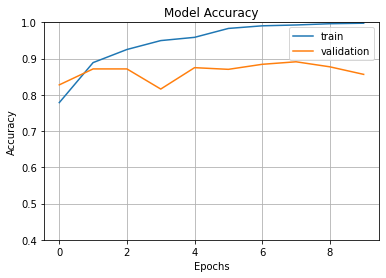

In [15]:
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

In [16]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

# Making Predictions

In [17]:
data_dir = DATASET_PATH
print(data_dir)

../input/flowersrecognition/flowers


In [18]:
flower_path_2 = os.path.join(DATASET_PATH, flowers_cls[random.randint(0,5)], '*')
print(flower_path_2)

../input/flowersrecognition/flowers/sunflower/*


In [19]:
flower_path_3 = glob.glob(flower_path_2)
image = io.imread(flower_path_3[339])
plt.imshow(image)
#print(flower_path_3)

In [20]:
print(flower_path_3[336])

../input/flowersrecognition/flowers/sunflower/6495559397_61d01c0c57.jpg


In [21]:
flowers_cls

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

In [22]:
# tf.keras.models.save_model(model,'my_model2.hdf5')
tf.keras.models.save_model(resnet_model,'flower_model.hdf5')


In [ ]:
# !pip install streamlit

In [23]:
%%writefile app.py
import streamlit as st
import tensorflow as tf
import streamlit as st


@st.cache(allow_output_mutation=True)
def load_model():
  #model=tf.keras.models.load_model('/content/flower_model.hdf5')
  model=tf.keras.models.load_model('./flower_model.hdf5') 
  return model
with st.spinner('Model is being loaded..'):
  model=load_model()

st.write("""
         # Flower Classification
         """
         )

file = st.file_uploader("Please upload an image of any of the following flowers - daisy, dandelion, rose, sunflower, tulip", type=["jpg", "png"])
import cv2
from PIL import Image, ImageOps
import numpy as np
st.set_option('deprecation.showfileUploaderEncoding', False)
def import_and_predict(image_data, model):
    
        size = (180,180)    
        image = ImageOps.fit(image_data, size, Image.ANTIALIAS)
        image = np.asarray(image)
        img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        #img_resize = (cv2.resize(img, dsize=(75, 75),    interpolation=cv2.INTER_CUBIC))/255.
        
        img_reshape = img[np.newaxis,...]
    
        prediction = model.predict(img_reshape)
        
        return prediction
if file is None:
    st.text("Please upload an image file")
else:
    image = Image.open(file)
    st.image(image, use_column_width=True)
    predictions = import_and_predict(image, model)
    score = tf.nn.softmax(predictions[0])
    st.write(prediction)
    st.write(score)
    print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

Writing app.py


In [24]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip

--2021-08-04 20:57:08--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 54.174.143.90, 34.203.159.69, 34.192.220.41, ...
Connecting to bin.equinox.io (bin.equinox.io)|54.174.143.90|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13832437 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  13.19M  13.4MB/s    in 1.0s    

2021-08-04 20:57:10 (13.4 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13832437/13832437]



In [25]:
!unzip ngrok-stable-linux-amd64.zip

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [34]:
get_ipython().system_raw('./ngrok http 8501 &')

In [35]:
!curl -s http://localhost:4040/api/tunnels | python3 -c \
    'import sys, json; print("Execute the next cell and the go to the following URL: " +json.load(sys.stdin)["tunnels"][0]["public_url"])'

Execute the next cell and the go to the following URL: https://9a891812cd0e.ngrok.io


In [32]:
!pip install streamlit

     |████████████████████████████████| 7.9 MB 5.3 MB/s eta 0:00:01
     |████████████████████████████████| 4.2 MB 8.5 MB/s eta 0:00:01
     |████████████████████████████████| 75 kB 2.2 MB/s  eta 0:00:01


In [36]:
!streamlit run ./app.py


  You can now view your Streamlit app in your browser.

  Network URL: http://172.19.2.2:8501
  External URL: http://34.79.37.79:8501

2021-08-04 21:10:06.445848: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-08-04 21:10:06.446174: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
^C
  Stopping...
